In [1]:
import itertools
import numpy as np
import pandas as pd
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
def grid_search_sarimax(
    y,
    p_range=(0, 3),
    d_range=(0, 2),
    q_range=(0, 3),
    P_range=(0, 2),
    D_range=(0, 2),
    Q_range=(0, 2),
    s=12,
    trend_options=("n", "c"),  # "n" sin constante, "c" con drift/constante
    max_iter=200,
):
    """
    Devuelve un DataFrame con resultados ordenados por AIC.
    y debe ser una Serie pandas indexada por fecha.
    """
    results = []
    orders = list(itertools.product(range(*p_range), range(*d_range), range(*q_range)))
    s_orders = list(itertools.product(range(*P_range), range(*D_range), range(*Q_range)))

    warnings.filterwarnings("ignore")

    for order in orders:
        for s_order in s_orders:
            seasonal_order = (s_order[0], s_order[1], s_order[2], s)
            for trend in trend_options:
                # evita combinaciones triviales (p=d=q=0 y P=D=Q=0)
                if order == (0, 0, 0) and s_order == (0, 0, 0):
                    continue

                try:
                    model = SARIMAX(
                        y,
                        order=order,
                        seasonal_order=seasonal_order,
                        trend=trend,
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    )
                    res = model.fit(disp=False, maxiter=max_iter)

                    resid = res.resid.dropna()
                    # Ljung-Box para autocorrelación en residuos (p-value)
                    lb_p = float(acorr_ljungbox(resid, lags=[12], return_df=True)["lb_pvalue"].iloc[0])

                    results.append({
                        "order": order,
                        "seasonal_order": seasonal_order,
                        "trend": trend,
                        "aic": res.aic,
                        "bic": res.bic,
                        "llf": res.llf,
                        "ljungbox_p(12)": lb_p,
                        "converged": bool(getattr(res, "mle_retvals", {}).get("converged", True)),
                    })

                except Exception:
                    # fallos de convergencia / singularidades, etc.
                    continue

    warnings.filterwarnings("default")

    df = pd.DataFrame(results)
    if df.empty:
        return df

    # Reglas típicas: residuos "bien" si Ljung-Box p > 0.05
    df["residuals_ok"] = df["ljungbox_p(12)"] > 0.05

    # Ordena priorizando: residuos ok, luego AIC
    df = df.sort_values(by=["residuals_ok", "aic"], ascending=[False, True]).reset_index(drop=True)
    return df

In [13]:
serie = pd.read_csv(
    "../data/processed/serie_mensual.csv",
    index_col=0,
    parse_dates=True
).squeeze()

In [14]:
s = 12
train = serie.iloc[:-s]
test = serie.iloc[-s:]

In [15]:
# Transformación logarítmica
train = np.log(train)
test = np.log(test)

In [ ]:
# y = tu serie (idealmente en log si así modelas)
# y = np.log(df["price"]).asfreq("MS")  # ejemplo

In [6]:
df_grid = grid_search_sarimax(
    train,
    p_range=(0, 3), d_range=(0, 2), q_range=(0, 3),
    P_range=(0, 2), D_range=(0, 2), Q_range=(0, 2),
    s=12,
    trend_options=("n", "c")
)

df_grid.head(15)

,order,seasonal_order,trend,aic,bic,llf,ljungbox_p(12),converged,residuals_ok
0,"(0, 1, 1)","(1, 0, 1, 12)",c,-383.795979,-369.735057,196.897989,0.999920,True,True
1,"(0, 1, 1)","(1, 0, 0, 12)",c,-382.631673,-371.318418,195.315837,1.000000,False,True
2,"(1, 1, 1)","(1, 0, 1, 12)",c,-382.509687,-365.636581,197.254844,0.999618,True,True
3,"(1, 0, 1)","(0, 0, 1, 12)",n,-381.414653,-370.133526,194.707326,1.000000,True,True
4,"(0, 1, 1)","(0, 0, 1, 12)",c,-381.197830,-369.949093,194.598915,1.000000,True,True
5,"(1, 1, 2)","(0, 0, 1, 12)",c,-381.070174,-364.246048,196.535087,0.205126,True,True
6,"(0, 1, 1)","(1, 0, 1, 12)",n,-380.934065,-369.685328,194.467033,0.999992,True,True
7,"(2, 1, 1)","(1, 0, 1, 12)",c,-380.509607,-360.824316,197.254803,0.999622,True,True
8,"(1, 1, 1)","(1, 0, 0, 12)",c,-380.473840,-366.372432,195.236920,1.000000,True,True
9,"(1, 1, 2)","(1, 0, 0, 12)",c,-380.375405,-363.453716,196.187702,0.091078,True,True


In [8]:
cand = df_grid[(df_grid["converged"] == True) & (df_grid["residuals_ok"] == True)].copy()
cand = cand.sort_values(["aic", "bic"], ascending=[True, True])
cand.head(5)

,order,seasonal_order,trend,aic,bic,llf,ljungbox_p(12),converged,residuals_ok
0,"(0, 1, 1)","(1, 0, 1, 12)",c,-383.795979,-369.735057,196.897989,0.999920,True,True
2,"(1, 1, 1)","(1, 0, 1, 12)",c,-382.509687,-365.636581,197.254844,0.999618,True,True
3,"(1, 0, 1)","(0, 0, 1, 12)",n,-381.414653,-370.133526,194.707326,1.000000,True,True
4,"(0, 1, 1)","(0, 0, 1, 12)",c,-381.197830,-369.949093,194.598915,1.000000,True,True
5,"(1, 1, 2)","(0, 0, 1, 12)",c,-381.070174,-364.246048,196.535087,0.205126,True,True


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
def fit_forecast(y_train, y_test, order, seasonal_order, trend):
    model = SARIMAX(
        y_train,
        order=eval(order) if isinstance(order, str) else order,
        seasonal_order=eval(seasonal_order) if isinstance(seasonal_order, str) else seasonal_order, 
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False, maxiter=500)
    pred = res.get_forecast(steps=len(y_test)).predicted_mean
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    train_exp = np.exp(y_train)
    y_test_exp = np.exp(y_test)
    pred_exp = np.exp(pred)
    # Gráfico
    plt.figure(figsize=(10,6))
    plt.plot(train_exp, label="Train")
    plt.plot(y_test_exp, label="Test")
    plt.plot(pred_exp, label="SARIMAX")
    plt.legend()
    plt.title("SARIMAX - Serie Original")
    plt.show()
    return mae, rmse, res.aic, res.bic

c:\Users\danie\anaconda3\envs\mineria_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


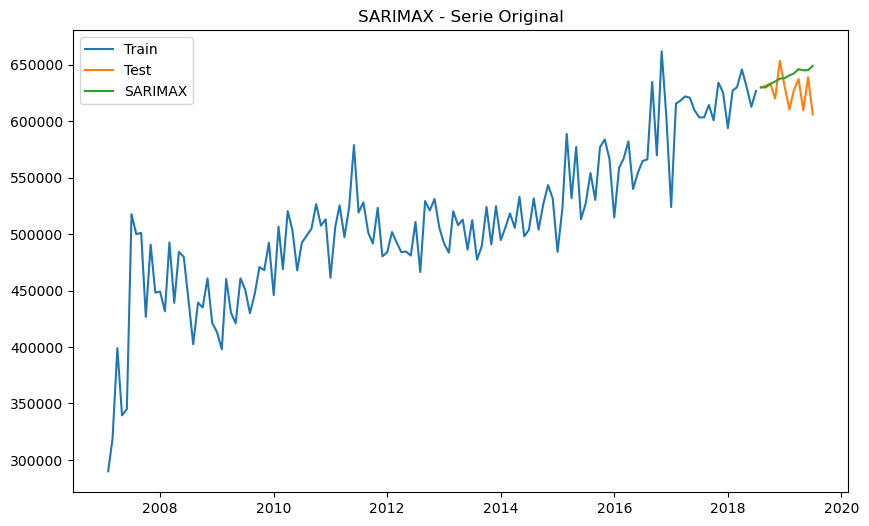

(0, 1, 1) (1, 0, 1, 12) c MAE: 0.02362277562236681 RMSE: 0.03209974971751489 AIC: -383.7959789239613 BIC: -369.7350571470992


c:\Users\danie\anaconda3\envs\mineria_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


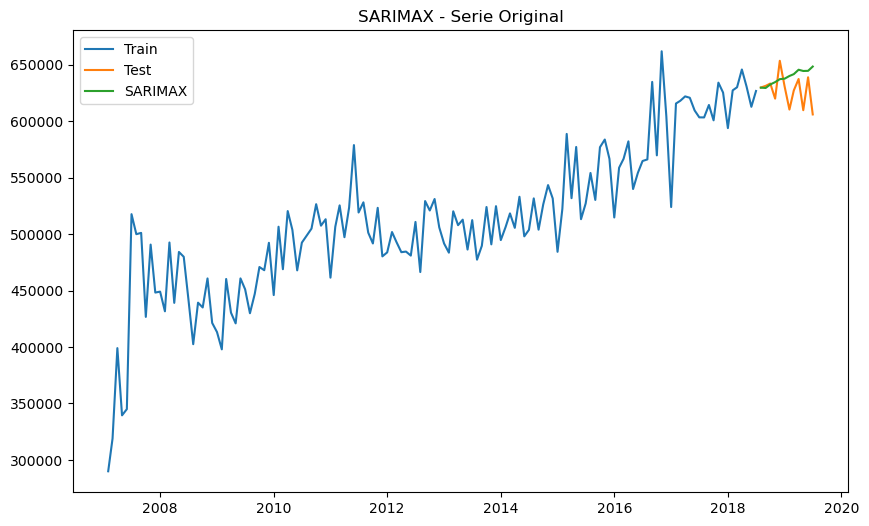

(1, 1, 1) (1, 0, 1, 12) c MAE: 0.023236906737028235 RMSE: 0.031582203091759964 AIC: -382.50968728752605 BIC: -365.63658115529154


c:\Users\danie\anaconda3\envs\mineria_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


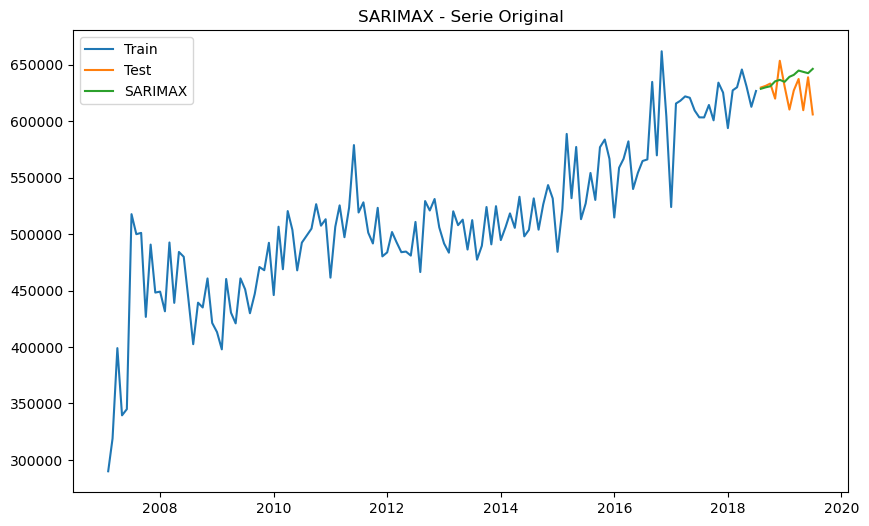

(1, 0, 1) (0, 0, 1, 12) n MAE: 0.022409025987349136 RMSE: 0.030591018266032808 AIC: -381.41465252329596 BIC: -370.1335262608758


In [21]:
top = cand.head(3)

for _, r in top.iterrows():
    mae, rmse, aic, bic = fit_forecast(train, test, r["order"], r["seasonal_order"], r["trend"])
    print(r["order"], r["seasonal_order"], r["trend"], "MAE:", mae, "RMSE:", rmse, "AIC:", aic, "BIC:", bic)

In [23]:
# obtener el mejor modelo (el primero de cand)
best = cand.iloc[0]
print("Mejor modelo encontrado:")
print("Order:", best["order"])
print("Seasonal Order:", best["seasonal_order"])
print("Trend:", best["trend"])


Mejor modelo encontrado:
Order: (0, 1, 1)
Seasonal Order: (1, 0, 1, 12)
Trend: c
